In [33]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


# MANGA Dataset
---

### Preprocessing

In [60]:
# Training and Validation data
transforms = v2.Compose([
    v2.Resize((64, 64)), # Resize to 224x224
    v2.ToTensor(),
    v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), # Normalize
])

# Create Datasets for Training and Validation
PATH = './animeface-character-dataset/animeface-character-dataset' 
train_dataset = ImageFolder(PATH, transform=transforms)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [61]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 9754
    Root location: ./animeface-character-dataset/animeface-character-dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToTensor()
                 Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=False)
           )

In [62]:
# Create a DataLoader for batching and shuffling the data
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Generator
---

In [63]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(noise_size, maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.ReLU(True),
            # state size. (maps*8) x 4 x 4
            nn.ConvTranspose2d(maps * 8, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.ReLU(True),
            # state size. (maps*4) x 8 x 8
            nn.ConvTranspose2d(maps * 4, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.ReLU(True),
            # state size. (maps*2) x 16 x 16
            nn.ConvTranspose2d(maps * 2, maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps),
            nn.ReLU(True),
            # state size. (maps) x 32 x 32
            nn.ConvTranspose2d(maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, x):
        return self.model(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


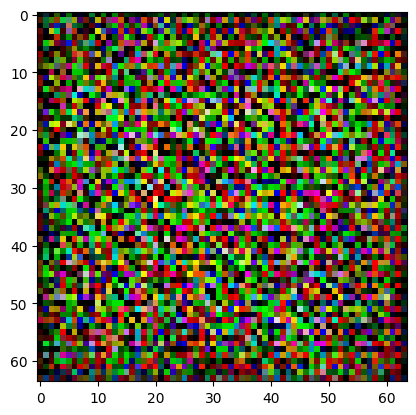

In [64]:
generator = Generator()
noise = torch.randn(64, 128, 1, 1)
output = generator(noise)
plt.imshow(output[0].detach().numpy().transpose(1, 2, 0))
plt.show()

# Discriminator
---

In [65]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (3) x 64 x 64
            nn.Conv2d(3, maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps) x 32 x 32
            nn.Conv2d(maps, maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*2) x 16 x 16
            nn.Conv2d(maps * 2, maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*4) x 8 x 8
            nn.Conv2d(maps * 4, maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (maps*8) x 4 x 4
            nn.Conv2d(maps * 8, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [66]:
# Instantiate the discriminator
discriminator = Discriminator()
output_discriminator = discriminator(output)
output_discriminator.shape

torch.Size([64, 1])

In [67]:
output.shape

torch.Size([64, 3, 64, 64])

# Compiler
---

In [68]:
class DCGAN(nn.Module):
    def __init__(self, discriminator, generator, latent_size):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_size = latent_size
    
    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss = nn.BCELoss()
        self.d_loss_metric = torch.tensor(0.0)
        self.g_loss_metric = torch.tensor(0.0)

    def train_step(self, real_images):
        batch_size = real_images.size(0)
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)

        # Train Generator
        self.g_optimizer.zero_grad()
        # Sample noise as generator input
        z = torch.randn(batch_size, self.latent_size, 1, 1)
        # Generate a batch of images
        gen_imgs = self.generator(z)
        # Loss measures generator's ability to fool the discriminator
        print(gen_imgs.size(), self.discriminator(gen_imgs).size(), valid.size())
        g_loss = self.loss(self.discriminator(gen_imgs), valid)
        g_loss.backward()
        self.g_optimizer.step()

        # Train Discriminator
        self.d_optimizer.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        print(self.discriminator(real_images))
        real_loss = self.loss(torch.mean(self.discriminator(real_images), 1).unsqueeze(1), valid)
        fake_loss = self.loss(self.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        self.d_optimizer.step()

        # self.d_loss_metric = d_loss
        self.g_loss_metric = g_loss
        return {"d_loss": d_loss, "g_loss": g_loss}

In [69]:
DCGAN_model = DCGAN(discriminator, generator, 128)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [70]:
DCGAN_model.compile(d_optimizer, g_optimizer)

In [71]:
check = next(iter(dataloader))[0]
check.shape

torch.Size([32, 3, 64, 64])

In [75]:
##### Rashmi: I wasnt sure why the train loop was in the complier model class above so tried different way below 
# since we have already defined gen and disc classes we can just initialize gen, disc, optimizers, and loss 
# and then run the train loop

generator = Generator()
discriminator = Discriminator()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()


# Training Loop
num_epochs = 5
latent_size = 128

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images
        batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, latent_size, 1, 1)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        g_optimizer.step()

        # Train the discriminator
        d_optimizer.zero_grad()
        real_outputs = discriminator(real_images)
        d_real_loss = criterion(real_outputs, real_labels)
        fake_outputs = discriminator(fake_images.detach())
        d_fake_loss = criterion(fake_outputs, fake_labels)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")

# Generate samples for visualization
with torch.no_grad():
    z = torch.randn(16, latent_size)
    fake_samples = generator(z).reshape(-1, 1, 28, 28)
    fake_samples = (fake_samples + 1) / 2  # Rescale to [0, 1] for visualization

# Visualize generated samples
grid_img = vutils.make_grid(fake_samples, nrow=4, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.title(f"Generated Samples - Epoch {epoch+1}")
plt.show()

### had to stop bc my laptop was going to explode but code is working 




Epoch [1/5], Step [100/305], Generator Loss: 3.9172, Discriminator Loss: 0.2037
Epoch [1/5], Step [200/305], Generator Loss: 5.1785, Discriminator Loss: 0.3722
Epoch [1/5], Step [300/305], Generator Loss: 1.5801, Discriminator Loss: 0.3375
Epoch [2/5], Step [100/305], Generator Loss: 2.0873, Discriminator Loss: 0.4978
Epoch [2/5], Step [200/305], Generator Loss: 2.6860, Discriminator Loss: 0.2443
Epoch [2/5], Step [300/305], Generator Loss: 1.8844, Discriminator Loss: 0.2944
Epoch [3/5], Step [100/305], Generator Loss: 1.8018, Discriminator Loss: 0.3964
Epoch [3/5], Step [200/305], Generator Loss: 2.2553, Discriminator Loss: 0.3229
Epoch [3/5], Step [300/305], Generator Loss: 3.3894, Discriminator Loss: 0.3967
Epoch [4/5], Step [100/305], Generator Loss: 3.6083, Discriminator Loss: 0.2885


KeyboardInterrupt: 